In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range
from sklearn.model_selection import train_test_split

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
#get the data set with clean reviews
train = pd.read_csv("clean_train_reviewsbg.csv")

In [3]:
#import the word2vec model with gensim
import gensim

In [4]:
#load word2vec
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit=500000)


C:\Users\ngmat\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [5]:
#change reviews to vectors space anf get the average vector for each review
def review_to_vector(review):
    review_array = review.split()
    wordvectors = []
    for word in review_array:
        try:
            vector = model.get_vector(word)
            wordvectors.append(vector)
        except KeyError:
            pass
    avg_word_vector = np.mean(np.array(wordvectors), axis=0)
    return avg_word_vector

In [6]:
cleanvector = []
for review in train['cleanReview']:
    cleanvector.append(review_to_vector(review))

In [7]:
X_emreviews = np.array(cleanvector, dtype=np.float)
X_emreviews.shape

(25000, 300)

In [8]:
print(X_emreviews[1])

[ 0.03917618  0.07527008  0.00668135  0.12237892 -0.05514144  0.01250296
  0.04666138 -0.04853227  0.06809974  0.06034899 -0.0264349  -0.13563843
 -0.02281494  0.04036713 -0.0774643   0.1085742   0.03467331  0.12186289
  0.01463499 -0.05926056 -0.03535689  0.07528882  0.02703972  0.00123997
  0.04615135 -0.03957943 -0.09244518  0.0536674   0.00888844 -0.00864553
 -0.06121502 -0.01299958 -0.01968536  0.03419232  0.05326509  0.0030509
  0.03214207  0.04327729  0.05265088  0.09054108  0.11198883 -0.01156807
  0.10114269  0.02941818 -0.02399211 -0.05242996 -0.06253014 -0.00025215
  0.03833618 -0.01486816 -0.01893005  0.03220692 -0.04692974  0.01528053
  0.02531347  0.02246552 -0.04301932 -0.09034767  0.02570829 -0.07500491
  0.01776581  0.09853458 -0.09504414 -0.08185279  0.0098011  -0.03730826
 -0.1026289   0.06098423 -0.02648797  0.07591248  0.0409565  -0.00612602
  0.07162933 -0.02266569 -0.12598877 -0.09535122  0.02087936  0.06742859
  0.06781578  0.10706339 -0.02486682 -0.02205276  0.

In [9]:
#train test split with features as vectors and the sentiment score 
train_features, test_features, train_labels, test_labels = train_test_split(X_emreviews, train['sentiment'], test_size = 0.33, random_state = 42)

In [10]:
#set up random forest fit and predict
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier()

In [11]:
rf2.fit(train_features, train_labels)

C:\Users\ngmat\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
sen_pred_train = rf2.predict(train_features)
sen_pred_test = rf2.predict(test_features)

In [13]:
#performance scores
from sklearn.metrics import accuracy_score
print('accuracy scores training set: ',accuracy_score(train_labels,sen_pred_train))
print('accuracy scores test set: ',accuracy_score(test_labels,sen_pred_test))

accuracy scores training set:  0.992
accuracy scores test set:  0.7562424242424243


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [15]:
print(classification_report(test_labels, sen_pred_test)) 

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      4105
           1       0.79      0.71      0.74      4145

   micro avg       0.76      0.76      0.76      8250
   macro avg       0.76      0.76      0.76      8250
weighted avg       0.76      0.76      0.76      8250



In [16]:
print(confusion_matrix(test_labels, sen_pred_test)) 

[[3310  795]
 [1216 2929]]


In [17]:
sen_pred_test_roc = rf2.predict_proba(test_features)
sen_pred_test_roc_positive = sen_pred_test_roc[:, 1]

In [18]:
auc = roc_auc_score(test_labels, sen_pred_test_roc_positive)
print('AUC: %.2f' % auc)

AUC: 0.83


In [19]:
fpr, tpr, thresholds = roc_curve(test_labels, sen_pred_test_roc_positive)

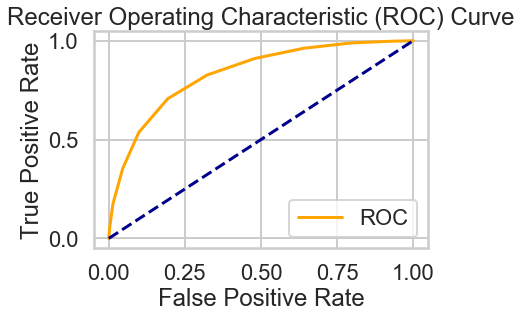

In [20]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV 

In [25]:
#hyper parameter tuning for random forest with parameters below
n_estimators = [4, 8, 32, 64, 100, 200, 300]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
gridparam = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [26]:
grid = GridSearchCV(estimator = rf2, param_grid = gridparam,  n_jobs = -1, verbose = 2)

In [27]:
#fit, predict, and get performance scores
grid.fit(train_features, train_labels)

C:\Users\ngmat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 231 candidates, totalling 693 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 693 out of 693 | elapsed: 44.6min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [4, 8, 32, 64, 100, 200, 300], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [28]:
print(grid.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [29]:
sen_pred_trainrf2bestn = grid.predict(train_features)
sen_pred_testrf2bestn = grid.predict(test_features)
print('accuracy scores training set: ',accuracy_score(train_labels,sen_pred_trainrf2bestn))
print('accuracy scores test set: ',accuracy_score(test_labels,sen_pred_testrf2bestn))
print(classification_report(test_labels, sen_pred_testrf2bestn)) 

accuracy scores training set:  1.0
accuracy scores test set:  0.824
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      4105
           1       0.81      0.85      0.83      4145

   micro avg       0.82      0.82      0.82      8250
   macro avg       0.82      0.82      0.82      8250
weighted avg       0.82      0.82      0.82      8250

